# Notebook to analyze Results from alevin with transcriptome index and alevin-fry with splici index

The purpose is to evaluate the how similar the results from alevin and alevin-fry are for different scRNA and snRNA-seq experiments.


This is done by looking at the number of cells/nuclei left after filtering, the overlap of barcodes and spearman correlation per cell. 

Functions for spearman boxplot are from https://github.com/COMBINE-lab/alevin-fry-paper-scripts.



In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy 
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob

In [4]:
#from https://github.com/COMBINE-lab/alevin-fry-paper-scripts.

def sp_corr_df(d1, d2, shared, shared_cells, kind="cells", thresh=1):
    '''
    Given 2 AnnData objects, a list of shared genes `shared` and 
    a list of shared cells `shared_cells`, compute the pariwise spearman 
    correlation of type `kind`.  If `kind` is "cells", then compute the 
    cellwise spearman correlations, if it is "genes" compute the genewise
    spearman correlations.  The result is a distribution (list) of correlation
    values.
    '''
    a = d1[shared_cells, shared].X.copy()
    b = d2[shared_cells, shared].X.copy()
    if kind == "cells":
        corrs = np.zeros(len(shared_cells))
        for i,c in enumerate(shared_cells):
            sr,p = sp.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    elif kind == "genes":
        a = a.T.tocsr()
        b = b.T.tocsr()
        corrs = np.zeros(len(shared))
        for i,c in enumerate(shared):
            sr,p = scipy.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    return corrs

In [17]:
#from https://github.com/COMBINE-lab/alevin-fry-paper-scripts.
def maximum (A, B):
    '''
    Select the maximum, entry-wise among matricies A and B.    
    '''
    # https://stackoverflow.com/questions/19311353/element-wise-maximum-of-two-sparse-matrices
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data < 0, 1, 0)
    return A - A.multiply(BisBigger) + B.multiply(BisBigger)

In [18]:
#from https://github.com/COMBINE-lab/alevin-fry-paper-scripts.
def get_metrics(truth, pred_in):
    '''
    Compute and return the metrics we are evaluating.
    '''  
    shared_obs = pred_in.obs.index.intersection(truth.obs.index)
    shared_var = pred_in.var.index.intersection(truth.var.index)

    truth_filt = truth[shared_obs, shared_var].copy()
    pred = pred_in[shared_obs, shared_var].copy()
    #entry_rd = (pred.X - truth_filt.X) / maximum(truth_filt.X, pred.X)
    #entry_ard_nonan = np.abs(entry_rd[~np.isnan(entry_rd)])
    #mard_drop_nan = entry_ard_nonan.mean()
    
    #entry_rdc = entry_rd.copy()
    #entry_rdc[np.isnan(entry_rdc)] = 0.0
    #mard_nan_zero = np.abs(entry_rdc).mean()
    
    spearmans = sp_corr_df(truth_filt, pred, pred.var_names, pred.obs_names)
    
    #fps = [np.logical_and(truth_filt.X[i,:].toarray() == 0, pred.X[i,:].toarray() > 0).sum() for i in range(pred.X.shape[0])]
    #num_expressed = [ np.sum(truth_filt.X[i,:].toarray() > 0) for i in range(pred.X.shape[0])]
    
    #fp_gene_per_cell = np.mean(np.array(fps)/np.array(num_expressed))
  
    #fns = [np.logical_and(truth_filt.X[i,:].toarray() > 0, pred.X[i,:].toarray() == 0).sum() for i in range(pred.X.shape[0])]
    #num_expressed = [ np.sum(truth_filt.X[i,:].toarray() > 0) for i in range(pred.X.shape[0])]
    
    #fn_gene_per_cell = np.mean(np.array(fns)/np.array(num_expressed))
    
    rd = {'spearmans' : spearmans}
    return rd

In [5]:
#from https://github.com/COMBINE-lab/alevin-fry-paper-scripts.
def print_summary_metrics(resdict):
    print('Mean per-cell Spearman correlation: {:.4f}'.format(resdict['spearmans'].mean()))
    print('MARD (dropping NANs) : {:.4f}'.format(resdict['mard_drop_nan']))
    print('MARD (setting NANs = 0) : {:.4f}'.format(resdict['mard']))
    print('rFP / cell : {:.4f}%'.format(100*resdict['fp_gene_per_cell']))
    print('rFN / cell : {:.4f}%'.format(100*resdict['fn_gene_per_cell']))

In [19]:
#from https://github.com/COMBINE-lab/alevin-fry-paper-scripts.
def get_shared(list_of_annd):
    shared_cells = list_of_annd[0].obs_names
    shared_genes = list_of_annd[0].var_names
    for annd in list_of_annd[1:]:
        shared_cells &= annd.obs_names
        shared_genes &= annd.var_names 
    return shared_cells, shared_genes

In [5]:
#from https://github.com/COMBINE-lab/alevin-fry-paper-scripts.
def legend_without_duplicate_labels(ax, loc='lower right'):
    '''
    from : https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    '''
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc=loc)

In [20]:
#from https://github.com/COMBINE-lab/alevin-fry-paper-scripts.
def plot_spearman_dists(mdict, plot_name):
    sns.set_context('poster')#, font_scale=1.4, rc={"lines.linewidth": 2})
    sns.set_style('white')
    datalist = []
    name_order = []
    for i, (mn, m) in enumerate(mdict.items()):
        name_order.append(mn)
        datalist += [(mn, e) for e in m['spearmans']]

    data = pd.DataFrame.from_records(datalist, columns=['method', 'per-cell Spearman corr.'])
    g = sns.boxenplot(data=data, y='method', x="per-cell Spearman corr.", hue='method', linewidth=0.5, dodge=False)
    g.set_xlabel('per/cell Spearman correlation')
    g.set_ylabel('method')
    fig = plt.gcf()
    fig.set_size_inches(10,8)
    sns.despine()
    plt.savefig(plot_name, bbox_inches='tight', dpi=300)

In [3]:
#from https://github.com/COMBINE-lab/alevin-fry-paper-scripts.
def get_res_summary(mdict):
    datalist = []
    for mn, m in mdict.items():
        datalist.append((mn, m['spearmans'].mean(), m['mard_drop_nan'], m['mard'], m['fp_gene_per_cell'], m['fn_gene_per_cell']))
    
    data = pd.DataFrame.from_records(datalist, 
        columns=['method', 'mean Spearman corr.', 'MARD (drop NA)', 'MARD (NA=0)', 'rFP/cell', 'rFN/cell'])
    return data

In [4]:
def get_exp_names(exp_list):
    name_list = []
    for i in exp_list:
        file_name = (os.path.basename(i))
        name = (file_name.split("_")[0])
        name_list.append(name)
    return name_list
    

In [5]:
def check_name_lists(name_list1, name_list2):
    if name_list1 == name_list2:
        print("exp_names are correct!")
    else:
        print("wrong names")
        
        

In [6]:
def print_dict(my_dict):
    print("{:<20} {:<20} {:<20} {:<20} {:<20}".format('Experiment','barcodes alevin-fry','barcodes alevin', 'total overlap', '% overlap'))
    for k, v in my_dict.items():
        bc_fry, bc_alevin, tot_ol, pct_ol = v
        print("{:<20} {:<20} {:<20} {:<20} {:<20}".format(k,bc_fry, bc_alevin, tot_ol, pct_ol))



In [12]:
def get_barcode_metrics(fry_path, alevin_path, names):
    metric_dict = {}
    for path_fry, path_alevin, name in zip(fry_path, alevin_path, names):
        print(name)
        fry = scanpy.read_h5ad(path_fry)
        alevin = scanpy.read_h5ad(path_alevin)
        intersect_barcodes = len(list(set(alevin.obs_names).intersection(fry.obs_names)))
        all_barcodes = intersect_barcodes +(len(alevin.obs_names)-intersect_barcodes) + (len(fry.obs_names)-intersect_barcodes)
        percent_intersection = np.round(intersect_barcodes/all_barcodes, decimals=2)
        metric_dict[name] = [len(fry.obs_names), len(alevin.obs_names), intersect_barcodes , percent_intersection]
    print_dict(metric_dict)

In [13]:
def make_exp_dict(fry_sn_path, alevin_sn_path, sn_names):
    exp_dict = {}
    for path_fry, path_alevin, name in zip(fry_sn_path, alevin_sn_path, sn_names):
        print(name)
        fry = scanpy.read_h5ad(path_fry, as_sparse="X")
        alevin = scanpy.read_h5ad(path_alevin, as_sparse="X")
        shared_cells, shared_genes = get_shared([fry, alevin])
        fry_res = get_metrics(fry[shared_cells, shared_genes], alevin[shared_cells, shared_genes])
        exp_dict[name] =  fry_res
    return(exp_dict)

# Start of analysis

The functions we will need to read and process the data are declared above and the analysis starts here.


Select the paths for experiments

In [ ]:
fry_sn_path=sorted(glob.glob("mtx_for_galaxy/galaxy_h5ad/E-MTAB-11104_frysn.h5ad") )
fry_sc_path=sorted(glob.glob("mtx_for_galaxy/galaxy_h5ad/*fry_sc")) 
alevin_sn_path=sorted(glob.glob("mtx_for_galaxy/galaxy_h5ad/E-MTAB-11104_alevin_sn*")) 
alevin_sc_path=sorted(glob.glob("mtx_for_galaxy/galaxy_h5ad/*alevin_sc*")) 
fry_path=sorted(glob.glob("mtx_for_galaxy/galaxy_h5ad/*fry_*")) 
alevin_path=sorted(glob.glob("mtx_for_galaxy/galaxy_h5ad/*alevin_*"))

In [ ]:
sc_names = get_exp_names(fry_sc_path)
sn_names = get_exp_names(fry_sn_path)
names = get_exp_names(alevin_path)

In [ ]:
alevin_sn_path

Plot the spearman distance for each experiement between alevin and alevin-fry on shared cells and genes for


a) snRNA

In [10]:
color = {'E-CURD-90' : (200/255.0, 184/255.0, 114/255.0),
        'E-ENAD-53' : (106/255.0, 123/255.0, 197/255.0) , 
          'E-GEOD-147601' : (117/255.0, 0/255.0, 117/255.0), 
          'E-MTAB-8751' : (191/255.0, 114/255.0, 106/255.0), 
          'E-MTAB-8848' : (0/255.0, 118/255.0, 0/255.0)}

In [ ]:
exp_dict = make_exp_dict(fry_sn_path, alevin_sn_path, sn_names)
plot_spearman_dists(exp_dict, 'example.pdf')

E-CURD-119
E-CURD-90
E-ENAD-53
E-GEOD-131882


![SNOWFALL](spearman_dist_sn.pdf)

b) scRNA

In [ ]:
color = {'E-CURD-90' : (200/255.0, 184/255.0, 114/255.0),
        'E-ENAD-53' : (106/255.0, 123/255.0, 197/255.0) , 
          'E-GEOD-147601' : (117/255.0, 0/255.0, 117/255.0), 
          'E-MTAB-8751' : (191/255.0, 114/255.0, 106/255.0), 
          'E-MTAB-8848' : (0/255.0, 118/255.0, 0/255.0)}

In [ ]:

sc_dict = make_exp_dict(fry_sc_path, alevin_sc_path, sc_names)
plot_spearman_dists(sc_dict)

In [ ]:
sn_dict = make_exp_dict(fry_sn_path, alevin_sn_path, sn_names)
plot_spearman_dists(sn_dict)

E-MTAB-11104


![SNOWFALL](spearman_dist_sc.pdf)

Get the number of overlapping barcodes for each experiment

In [18]:
get_barcode_metrics(fry_sc_path, alevin_sc_path, sc_names)

E-CURD-117
E-CURD-13
E-CURD-87
E-ENAD-30
E-GEOD-135922
E-GEOD-137537
E-GEOD-158761
E-MTAB-7417
E-MTAB-9221
Experiment           barcodes alevin-fry  barcodes alevin      total overlap        % overlap           
E-CURD-117           8410                 8201                 8182                 0.97                
E-CURD-13            8512                 7980                 7958                 0.93                
E-CURD-87            5083                 5023                 4983                 0.97                
E-ENAD-30            8124                 6806                 6566                 0.79                
E-GEOD-135922        19412                19721                18318                0.88                
E-GEOD-137537        1561                 4434                 1523                 0.34                
E-GEOD-158761        16750                9202                 8900                 0.52                
E-MTAB-7417          2193                 2207       

In [19]:
get_barcode_metrics(fry_sn_path, alevin_sn_path, sn_names)

E-CURD-119
E-CURD-90
E-ENAD-53
E-GEOD-131882
E-GEOD-147601
E-MTAB-8751
E-MTAB-8848
Experiment           barcodes alevin-fry  barcodes alevin      total overlap        % overlap           
E-CURD-119           37271                15700                15698                0.42                
E-CURD-90            1330                 611                  610                  0.46                
E-ENAD-53            15477                5141                 3184                 0.18                
E-GEOD-131882        45017                19433                19428                0.43                
E-GEOD-147601        25458                17770                17639                0.69                
E-MTAB-8751          7532                 6818                 4742                 0.49                
E-MTAB-8848          5763                 1331                 1330                 0.23                


Get a summary of the results, and print them as a table.

Plot the frequency decay of gene presence across cells

Read in the table for the mapping rates for each experiment

In [2]:
mapping_rate = pd.read_csv("mtx_for_galaxy/all_mapping_rates.tsv", delimiter="\t")

In [3]:
mapping_rate['tool']

0      Alevin-fry
1          Alevin
2      Alevin-fry
3          Alevin
4      Alevin-fry
          ...    
159    Alevin-fry
160        Alevin
161    Alevin-fry
162        Alevin
163    Alevin-fry
Name: tool, Length: 164, dtype: object

Make a boxplot for the mapping rates

([<matplotlib.axis.YTick at 0x16bd85ca0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

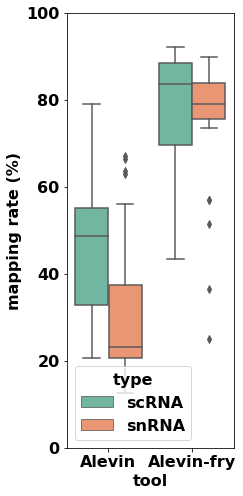

In [11]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': [3, 8]})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plot = sns.boxplot(x = 'tool', y = 'mapping rate (%)', hue = 'type', data=mapping_rate,  palette='Set2', order= ["Alevin", "Alevin-fry"])#  ax=ax[0])
#plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yticks(np.arange(0, 120, 20))

In [13]:
splice_ratio = pd.read_csv("mtx_for_galaxy/solice.tsv", delimiter="\t")

([<matplotlib.axis.YTick at 0x179bf6160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

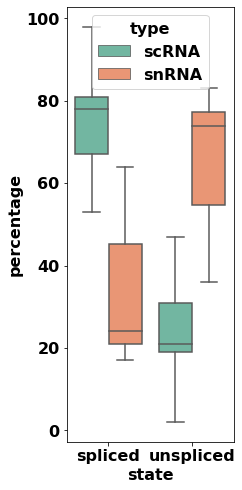

In [15]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': [3, 8]})
plot = sns.boxplot(x = 'state' , y = 'percentage',hue = 'type',  data= splice_ratio,  palette='Set2', hue_order= ['scRNA', 'snRNA'])#  ax=ax[0])
#plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yticks(np.arange(0, 120, 20))

In [16]:
mem = pd.read_csv("mtx_for_galaxy/memory.tsv", delimiter="\t")

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'E-CURD-117'),
  Text(1, 0, 'E-CURD-119'),
  Text(2, 0, 'E-ENAD-30'),
  Text(3, 0, 'E-GEOD-131882'),
  Text(4, 0, 'E-GEOD-134722'),
  Text(5, 0, 'E-GEOD-135922'),
  Text(6, 0, 'E-HCAD-30'),
  Text(7, 0, 'E-MTAB-11268'),
  Text(8, 0, 'E-MTAB-7417')])

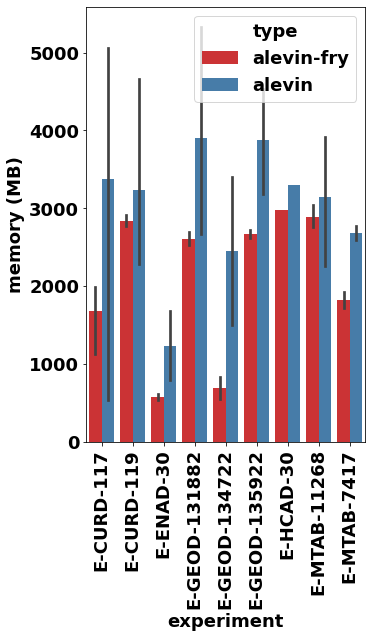

In [23]:
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [5, 8]})
plot = sns.barplot(x = 'experiment' , y = 'memory (MB)',hue = 'type',  data= mem ,  palette='Set1')#  ax=ax[0])
#plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.yticks(np.arange(0, 120, 20))
plt.xticks(rotation=90)

In [20]:
time = pd.read_csv("mtx_for_galaxy/time.tsv", delimiter="\t")

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'E-CURD-117'),
  Text(1, 0, 'E-CURD-119'),
  Text(2, 0, 'E-ENAD-30'),
  Text(3, 0, 'E-GEOD-131882'),
  Text(4, 0, 'E-GEOD-134722'),
  Text(5, 0, 'E-GEOD-135922'),
  Text(6, 0, 'E-HCAD-30'),
  Text(7, 0, 'E-MTAB-11268'),
  Text(8, 0, 'E-MTAB-7417')])

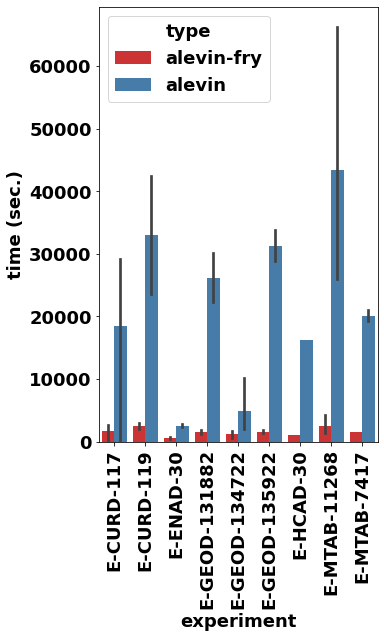

In [22]:
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [5, 8]})
plot = sns.barplot(x = 'experiment' , y = 'time (sec.)',hue = 'type',  data= time ,  palette='Set1')#  ax=ax[0])
#plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.yticks(np.arange(0, 120, 20))
plt.xticks(rotation=90)